In [1]:
# Ensure the module is automatically reloaded when rerunning the import command.
# %load_ext autoreload
# %autoreload 2

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from natsort import natsorted
import scipy.signal as sig


# indexing: c (count), j (window vertical), i (window horizontal)
# y (vertical top-bottom), x (horizontal left-right)
def read_image_directory(directory, prefix=None, image_type='png'):
    """
    TODO: Add documentation
    (i, y, x)
    """

    # Get a list of files in the directory
    files = os.listdir(directory)

    # If a prefix is specified, filter the list of files
    if prefix is not None:
        files = [f for f in files if f.startswith(prefix)]

    # If a type is specified, filter the list of files
    if image_type is not None:
        files = [f for f in files if f.endswith(image_type)]

    # Sort the files
    files = natsorted(files)

    # Read the images and store them in a 3D array
    images = np.array([cv.imread(os.path.join(directory, f),
                                 cv.IMREAD_GRAYSCALE) for f in files],
                      dtype=np.uint64)

    return images


def correlate_image_pair(image0, image1, method='correlate', plot=False):
    """
    TODO: Add documentation
    """

    # Compute the correlation between the two images using two methods
    if method == 'correlate':
        # correlation = sig.correlate(image1 - np.mean(image1),
        #                             image0 - np.mean(image0))
        correlation = sig.correlate(image1, image0)
    elif method == 'convolve':
        correlation = sig.fftconvolve(image1, image0[::-1, ::-1])
    else:
        raise ValueError('Invalid method')

    # If the plot option was set...
    if plot:
        # Plot the frames
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(image0, cmap='gray')
        ax[0].set_title('Frame 0')
        ax[0].set_xlabel('y [px]')
        ax[0].set_ylabel('x [px]')

        ax[1].imshow(image1, cmap='gray')
        ax[1].set_title('Frame 1')
        ax[1].set_xlabel('y [px]')
        ax[1].set_yticklabels([])
        plt.show()

        # Plot the correlation
        # TODO: Set size of extent correctly for inequal frame sizes
        ax_extent = [-image0.shape[1] + 0.5, image0.shape[1] - 0.5,
                     -image0.shape[0] + 0.5, image0.shape[0] - 0.5]

        # TODO: Set ticks based on image size
        ax_ticks = np.round(np.array(ax_extent) / 10) * 10

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(correlation, cmap='gray', interpolation='none',
                  extent=ax_extent)
        ax.set_xticks(np.arange(ax_ticks[0], ax_ticks[1] + 1, 10))
        ax.set_yticks(np.arange(ax_ticks[2], ax_ticks[3] + 1, 10))
        ax.set_title('Correlation')
        ax.set_xlabel('dy [px]')
        ax.set_ylabel('dx [px]')
        plt.show()

    return correlation


def find_displacement(correlation, subpixel_method='gauss_neighbor',
                      plot=False):
    """
    TODO: Add documentation
    """

    # Calculate the peak value of the cross-correlation
    peak = np.argwhere(np.amax(correlation) == correlation)

    # TODO: can be made faster with https://stackoverflow.com/a/58652335

    # If multiple maxima were found...
    if len(peak) > 1:
        # Error
        raise ValueError('Multiple equal maxima found in cross-correlation')
        # TODO: Handle multiple (neighbouring) maxima, if necessary
    else:
        # Take the first value if only one peak was found
        peak = peak[0]
        
    # If the peak is at the edge of the correlation array...
    if np.any(peak == np.array(correlation.shape - np.ones_like((1, 2)))):
        # Throw a warning
        print('Peak is at the edge of the correlation array')

    # If the subpixel option was set...
    elif subpixel_method is not None:
        # Refine the peak location
        correction = subpixel_refinement(correlation, peak, subpixel_method,
                                         plot=plot)
        peak = peak + np.array(correction)

    # Subtract the image center to get relative coordinates
    image_centre = (np.array(correlation.shape - np.ones_like((1, 2))) / 2)
    displacement = peak - image_centre

    return displacement


def subpixel_refinement(correlation, peak, method='gauss_neighbor', plot=False):
    """
    TODO: Add documentation
    """

    # Three-point offset calculation from the lecture
    if method == 'gauss_neighbor':

        # Get the neighbouring pixels in both dimensions
        neighbors = [correlation[(peak[0] - 1):(peak[0] + 2), peak[1]],
                     correlation[peak[0], (peak[1] - 1):(peak[1] + 2)]]

        # If the neighbors shape is not 3x3...
        if not all([neighbor.shape == (3,) for neighbor in neighbors]):
            fig, ax = plt.subplots()
            ax.imshow(correlation, cmap='gray')
            ax.plot(peak[1], peak[0], 'ro')
            plt.show()

        # Change all zeros to a small value to avoid division by zero
        # neighbors = [np.where(neighbor == 0, 1, neighbor) for neighbor in neighbors]

        # Three-point Gaussian fit in both dimensions
        correction = [(0.5 * (np.log(neighbor[0]) - np.log(neighbor[2]))
                       / ((np.log(neighbor[0])) + np.log(neighbor[2]) -
                          2 * np.log(neighbor[1]))) for neighbor in neighbors]

    else:
        raise ValueError('Invalid method')

    return correction


def assume_squareness(size):
    """
    
    PARAMETERS:
        size (int or tuple): Size of a window in pixels. If an integer is 
            supplied, the function turns this into a square window.
            
    RETURNS:
        size (np.array): Size of a window in pixels, as a 1D, 2-element array.
    """
    
    # Turn int or tuple into 1D array
    size = np.array([window_size]).flatten()
    
    # If the array has more than two elements, raise an error
    if size.size > 2:
        raise ValueError('The size should be a 1D array with 1 or 2 elements.')
    
    # If the size is a single element, assume a square window
    if len(size) == 1:
        size = np.array([size[0], size[0]])
    
    return size


def divide_in_windows(images, window_size, overlap=0):
    """
    TODO: Add documentation
    """
    
    # Process window_size, which may be an integer or tuple
    window_size = assume_squareness(window_size)
    
    # Check whether one or multiple images was supplied
    if len(images.shape) == 2:
        # If only one image was supplied, add a dimension
        images = images[np.newaxis, :, :]
    
    # Check whether the images can be evenly divided into windows of this size
    if not np.all([np.mod(images.shape[j+1], window_size[j]) == 0 for j in range(len(images.shape)-1)]):
        # Error
        raise ValueError(f'A {window_size} window does not fit into the images.')

    # Get the coordinates of the top left pixel of each window
    coordinates = np.array([[[y, x] for y in range(0, images.shape[1], window_size[0])] for x in range(0, images.shape[2], window_size[1])])

    # Divide the images into windows of size window_size
    windows = np.array([[[images[z, y:(y + window_size[0]), x:(x + window_size[1])]
                          for x in range(0, images.shape[2], window_size[1])] for y in range(0, images.shape[1], window_size[0])] for z in range(images.shape[0])])

    return windows, coordinates


def plot_flow_field(displacements, coordinates, window_size,
                    plot_windows=True, arrow_scale=1, calib_dist=None, 
                    units=None, title='Flow field'):
    """
    TODO: Add documentation
    """
    
    # Assume the window size is square
    window_size = assume_squareness(window_size)    
    
    # Plot all displacement vectors at the center of each window
    fig, ax = plt.subplots()
    
    # If a calibration distance was specified, calibrate all values
    if calib_dist is not None:
        displacements = displacements * calib_dist
        coordinates = coordinates * calib_dist
        window_size = window_size * calib_dist
    
    # Show a grid with the outline of each window and an arrow in the centre
    # indicating the displacement
    for j in range(len(coordinates[0])):
        for i in range(len(coordinates[1])):
            # Calculate the start and end of the arrow
            arrow_start = np.array([coordinates[j, i][0] + window_size[0] / 2 - 
                           arrow_scale * 0.5 * displacements[j, i][0], 
                           coordinates[j, i][1] + window_size[1] / 2 - 
                           arrow_scale * 0.5 * displacements[j, i][1]])

            # Plot the arrow
            ax.arrow(arrow_start[0], arrow_start[1],
                     arrow_scale * displacements[j, i][0],
                     arrow_scale * displacements[j, i][1],
                     width=1.5 * calib_dist,
                     head_width=10 * calib_dist,
                     head_length=7 * calib_dist,
                     fc='k', ec='k', lw=1)
            
            # Plot the window
            if plot_windows:
                ax.add_patch(plt.Rectangle((coordinates[j, i][0], 
                                       coordinates[j, i][1]), window_size[0],
                                       window_size[1], fill=None, edgecolor='darkgrey',
                                       linewidth=1))
            
    # Aspect ratio should be 1
    ax.set_aspect('equal')
    
    # Flip y axis
    ax.invert_yaxis()
    
    # If a calibration distance was specified, add units to the labels
    if calib_dist is not None:
        ax.set_xlabel(f'x [{units}]')
        ax.set_ylabel(f'y [{units}]')
    else:
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')

    ax.set_title(title)
    plt.show()
    
    return fig, ax

def plot_displacements(displacements, calib_dist=None, units=None, 
                       title='Displacement vectors'):
    """
    TODO: Add documentation
    """
    
    # If a calibration distance was specified, calibrate all values
    if calib_dist is not None:
        displacements = displacements * calib_dist
    
    # Plot all displacement vectors
    fig, ax = plt.subplots()
    ax.plot(displacements[:, :, 0].flatten(), displacements[:, :, 1].flatten(),
            'o', color='black', markersize=2)
    
    # Draw zero lines
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    
    # Pad the limits
    ax.set_xlim([np.amin(displacements[:, :, 0]) - 1, 
                 np.amax(displacements[:, :, 0]) + 1])
    ax.set_ylim([np.amin(displacements[:, :, 1]) - 1,
                    np.amax(displacements[:, :, 1]) + 1])
    
    ax.set_aspect('equal')
    
    # If a calibration distance was specified, add units to the labels
    if calib_dist is not None:
        ax.set_xlabel(f'Δx [{units}]')
        ax.set_ylabel(f'Δy [{units}]')
    else:
        ax.set_xlabel('Δx [px]')
        ax.set_ylabel('Δy [px]')

    ax.set_title(title)
    plt.show()
    
    return fig, ax
    

In [3]:
directory = 'PIVimages/shearflow/'
prefix = None
type = 'png'
images = read_image_directory(directory, prefix, type)

In [4]:
correlation = correlate_image_pair(images[0], images[1], plot=False)

In [5]:
displacement = find_displacement(correlation)

In [61]:
window_size = 64
windows, coordinates = divide_in_windows(images, window_size)

In [7]:
# Calculate the correlation of each window j,i in frame 0 with the 
# corresponding window in frame 1
correlations = np.array([[correlate_image_pair(
        windows[0, j, i], windows[1, j, i]) 
    for i in range(len(windows[0, 0]))] for j in range(len(windows[0, 1]))])

# Calculate the displacement of each window j,i in frame 0 with the
# corresponding window in frame 1
displacements = np.array([[find_displacement(correlation, plot=True) for 
                           correlation in row] for row in correlations])

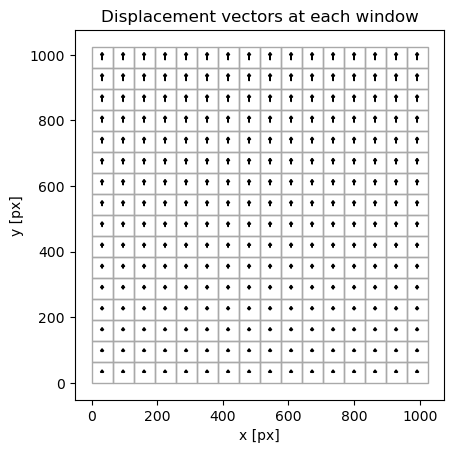

In [8]:
arrow_scale = 1

# Plot all displacements vectors at the center of each window
fig, ax = plt.subplots()

# Show a grid with the outline of each window and an arrow in the centre 
# indicating the displacement
for j in range(len(windows[0, 0])):
    for i in range(len(windows[0, 1])):
        # Calculate the start of the window
        arrow_start = (coordinates[j, i][0] + window_size / 2 - arrow_scale * 
                       0.5 * displacements[j, i][0], 
                       coordinates[j, i][1] + window_size / 2 - arrow_scale * 
                       0.5 * displacements[j, i][1])
        # center = (coordinates0[j, i][0] + window_size // 2, coordinates0[j, i][1] + window_size // 2)
        # Calculate the end of the arrow      
        # end = arrow_scale * (center[0] + displacements[j, i][0], center[1] + 
        #         displacements[j, i][1])
        # Plot the arrow
        # ax.arrow(center[0], center[1], arrow_scale * displacements[j, i][0], 
        #          arrow_scale * displacements[j, i][1], head_width=10, 
        #          head_length=7, 
        #          fc='k', ec='k', lw=1)
        ax.arrow(arrow_start[0], arrow_start[1], 
                 arrow_scale * displacements[j, i][0],
                 arrow_scale * displacements[j, i][1], 
                 head_width=10, head_length=7, fc='k', ec='k', lw=1)
        # Plot the window
        ax.add_patch(plt.Rectangle(
                (coordinates[j, i][0], coordinates[j,i][1]), window_size,
                window_size, fill=None, edgecolor='darkgrey', linewidth=1))
        
# Aspect ratio should be 1
ax.set_aspect('equal')

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('Displacement vectors at each window')

plt.show()


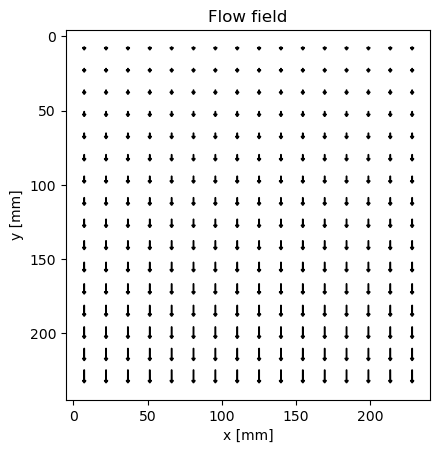

In [169]:
# Plot the flow field
_,_ = plot_flow_field(displacements, coordinates, window_size=window_size,
                calib_dist=0.23, units="mm", plot_windows=False, arrow_scale=2)

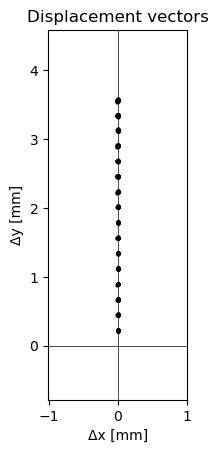

In [173]:
_, _ = plot_displacements(displacements, calib_dist=0.23, units="mm")

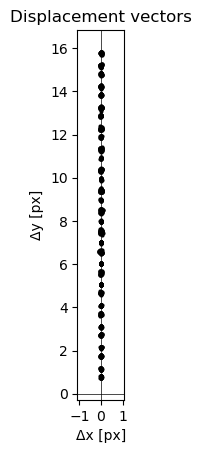

In [42]:
# Make a plot of all displacement vectors
fig, ax = plt.subplots()
ax.plot(displacements[:, :, 0].flatten(), displacements[:, :, 1].flatten(),
        'o', color='black', markersize=2)

# Draw zero lines
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Pad the limits
ax.set_xlim([np.amin(displacements[:, :, 0]) - 1, 
             np.amax(displacements[:, :, 0]) + 1])
ax.set_ylim([np.amin(displacements[:, :, 1]) - 1,
                np.amax(displacements[:, :, 1]) + 1])

ax.set_aspect('equal')
ax.set_xlabel('Δx [px]')
ax.set_ylabel('Δy [px]')
ax.set_title('Displacement vectors')
plt.show()


In [44]:
calibration_distance = 0.0001 # m/px
calibration_time = 0.01 # s/frame

# Calibrate the displacement vectors
displacements_calibrated = displacements * calibration_distance

# Calculate the velocity vectors
velocities = displacements_calibrated / calibration_time